In [1]:
import psfr
from psfr.psfr import shift_psf, one_step_psf_estimate

import astropy.io.fits as pyfits
import os
import matplotlib.pyplot as plt
import numpy as np
import copy
import scipy
from scipy.ndimage import interpolation
from lenstronomy.Util import util, kernel_util, image_util
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

%load_ext autoreload
%autoreload 2


vmin, vmax = -5, -1  # log10 minimum and maximum scale being plotted in PSF

In [2]:
# We export the five stars from JWST filter F090W that are in the Data folder
from psfr.util import jwst_example_stars
star_list_jwst = jwst_example_stars()


/var/folders/ff/391hnrfx0v757ybq_pmrkk_w0000gn/T/ipykernel_2688/1166516076.py:5: RuntimeWarning: invalid value encountered in log10
  im = ax.imshow(np.log10(star), origin='lower')


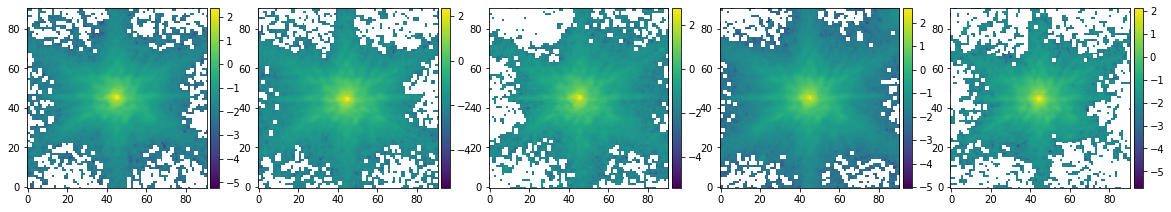

In [3]:
# make plot of stars
f, axes = plt.subplots(1, len(star_list_jwst), figsize=(4*len(star_list_jwst), 4), sharex=False, sharey=False)
for i, star in enumerate(star_list_jwst):
    ax = axes[i]
    im = ax.imshow(np.log10(star), origin='lower')
    ax.autoscale(False)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
plt.show()                    


## Using photutils to reconstruct PSF
This code is for comparison purpose with a well-established library.


In [4]:

from photutils.psf import EPSFStar
from photutils.psf import EPSFStars
from photutils.psf import EPSFBuilder

star_list_epsf = []
for star_ in star_list_jwst:
    x_grid, y_grid = util.make_grid(numPix=len(star_), deltapix=1, left_lower=True)
    x_grid, y_grid = util.array2image(x_grid), util.array2image(y_grid) 
    x_c, y_c = np.sum(star_ * x_grid)/np.sum(star_), np.sum(star_ * y_grid)/np.sum(star_)
    c_ = (len(star_) - 1) / 2
    x_s, y_s = x_c, y_c
    x_s, y_s = 2*c_ - y_c, 2*c_ - x_c
    star_list_epsf.append(EPSFStar(star_, cutout_center=[x_s, y_s]))

stars_epsf = EPSFStars(star_list_epsf)

oversampling = 4
epsf_builder_super = EPSFBuilder(oversampling=oversampling, maxiters=1, progress_bar=False)  
epsf_super, fitted_stars = epsf_builder_super(stars_epsf)

epsf_builder = EPSFBuilder(oversampling=1, maxiters=5, progress_bar=False)  
epsf, fitted_stars = epsf_builder(stars_epsf)


/var/folders/ff/391hnrfx0v757ybq_pmrkk_w0000gn/T/ipykernel_2688/1198511435.py:8: RuntimeWarning: divide by zero encountered in log10
  im = ax.imshow(np.log10(epsf_super.data), origin='lower', vmin=vmin, vmax=vmax)
/var/folders/ff/391hnrfx0v757ybq_pmrkk_w0000gn/T/ipykernel_2688/1198511435.py:8: RuntimeWarning: invalid value encountered in log10
  im = ax.imshow(np.log10(epsf_super.data), origin='lower', vmin=vmin, vmax=vmax)
/var/folders/ff/391hnrfx0v757ybq_pmrkk_w0000gn/T/ipykernel_2688/1198511435.py:16: RuntimeWarning: invalid value encountered in log10
  im = ax.imshow(np.log10(epsf_degraded), origin='lower', vmin=vmin, vmax=vmax)
/var/folders/ff/391hnrfx0v757ybq_pmrkk_w0000gn/T/ipykernel_2688/1198511435.py:24: RuntimeWarning: invalid value encountered in log10
  im = ax.imshow(np.log10(epsf_regular), origin='lower', vmin=vmin, vmax=vmax)


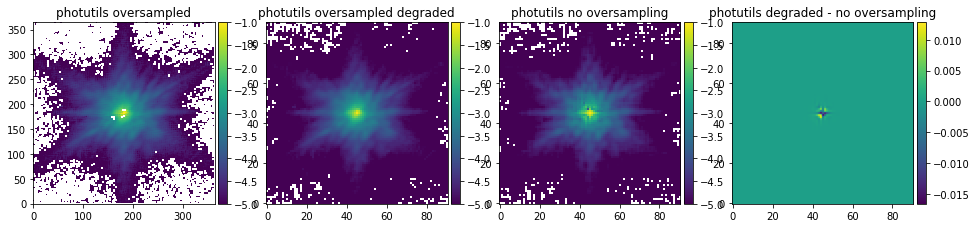

In [5]:

epsf_degraded = kernel_util.degrade_kernel(epsf_super.data, oversampling)
epsf_degraded = kernel_util.cut_psf(epsf_degraded, len(star_list_jwst[0]))
epsf_regular = kernel_util.cut_psf(epsf.data, len(star_list_jwst[0]))

f, axes = plt.subplots(1, 4, figsize=(4*4, 4), sharex=False, sharey=False)

ax = axes[0]
im = ax.imshow(np.log10(epsf_super.data), origin='lower', vmin=vmin, vmax=vmax)
ax.autoscale(False)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
ax.set_title('photutils oversampled')

ax = axes[1]
im = ax.imshow(np.log10(epsf_degraded), origin='lower', vmin=vmin, vmax=vmax)
ax.autoscale(False)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
ax.set_title('photutils oversampled degraded')

ax = axes[2]
im = ax.imshow(np.log10(epsf_regular), origin='lower', vmin=vmin, vmax=vmax)
ax.autoscale(False)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
ax.set_title('photutils no oversampling')

ax = axes[3]
im = ax.imshow(epsf_degraded - epsf_regular, origin='lower')
ax.autoscale(False)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
ax.set_title('photutils degraded - no oversampling')

plt.show()


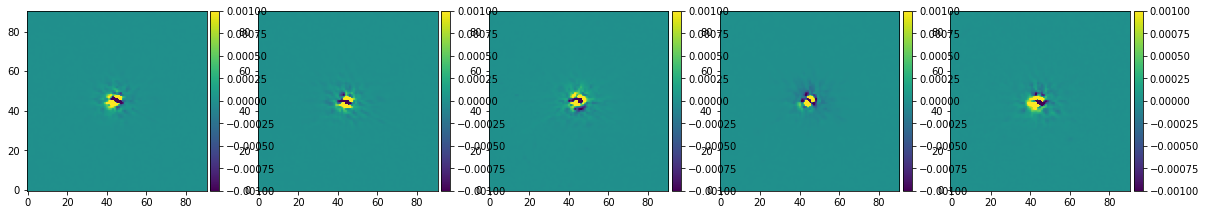

In [6]:


def plot_individual_fit_photutils(epsf, fitted_stars, oversampling):


    f, axes = plt.subplots(1, len(fitted_stars), figsize=(4*len(fitted_stars), 4), sharex=False, sharey=False)
    for i, star in enumerate(fitted_stars):
        
        # retriev shift
        n_c = (len(star.data)-1) /2
        shift = star.cutout_center - np.array([n_c, n_c])
        psf_degraded = shift_psf(epsf.data, oversampling, shift, degrade=True, n_pix_star=len(star.data))
        ax = axes[i]
        im = ax.imshow(psf_degraded/np.sum(psf_degraded) - star.data/np.sum(star.data), origin='lower', vmin=-0.001, vmax=0.001)
        ax.autoscale(False)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)
    plt.show()


plot_individual_fit_photutils(epsf_super, fitted_stars, oversampling)
    

## now the PSF-r code for stacking

In [24]:

from psfr.psfr import stack_psf
kwargs_psf_stacking = {'stacking_option': 'mean'}
# stacking_option : option of stacking, 'mean',  'median' or 'median_weight'

psf_psfr, center_list_psfr, mask_list = stack_psf(star_list_jwst, oversampling=1, 
                                                  saturation_limit=None, num_iteration=100, 
                                                  n_recenter=5, kwargs_psf_stacking=kwargs_psf_stacking)

psf_psfr_super, center_list_psfr_super, mask_list = stack_psf(star_list_jwst, oversampling=oversampling, 
                                                              saturation_limit=None, num_iteration=100, 
                                                              n_recenter=5, 
                                                              kwargs_psf_stacking=kwargs_psf_stacking)




/var/folders/ff/391hnrfx0v757ybq_pmrkk_w0000gn/T/ipykernel_2688/3876729393.py:10: RuntimeWarning: invalid value encountered in log10
  im = ax.imshow(np.log10(psf_psfr_super * oversampling**2), origin='lower', vmin=vmin, vmax=vmax)


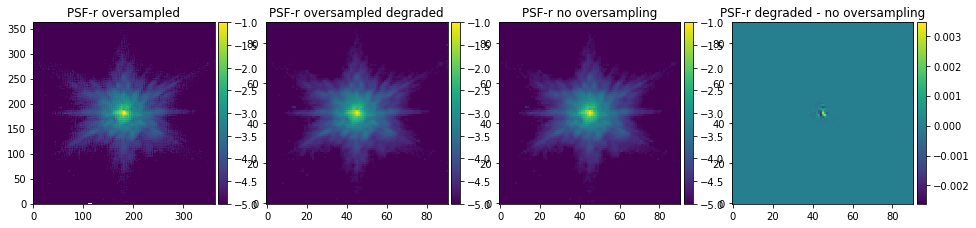

In [25]:
# comparison between degraded and supersampled


psf_psfr_super_degraded = kernel_util.degrade_kernel(psf_psfr_super, oversampling)
psf_psfr_super_degraded = kernel_util.cut_psf(psf_psfr_super_degraded, len(psf_psfr))

f, axes = plt.subplots(1, 4, figsize=(4*4, 4), sharex=False, sharey=False)

ax = axes[0]
im = ax.imshow(np.log10(psf_psfr_super * oversampling**2), origin='lower', vmin=vmin, vmax=vmax)
ax.autoscale(False)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
ax.set_title('PSF-r oversampled')

ax = axes[1]
im = ax.imshow(np.log10(psf_psfr_super_degraded), origin='lower', vmin=vmin, vmax=vmax)
ax.autoscale(False)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
ax.set_title('PSF-r oversampled degraded')

ax = axes[2]
im = ax.imshow(np.log10(psf_psfr), origin='lower', vmin=vmin, vmax=vmax)
ax.autoscale(False)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
ax.set_title('PSF-r no oversampling')

ax = axes[3]
im = ax.imshow(psf_psfr_super_degraded - psf_psfr, origin='lower')
ax.autoscale(False)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
ax.set_title('PSF-r degraded - no oversampling')

plt.show()

0.0001208242279720029
9.143298148981015e-05
0.0002632787547888424
0.0006289398503665009
0.00015139746720837572


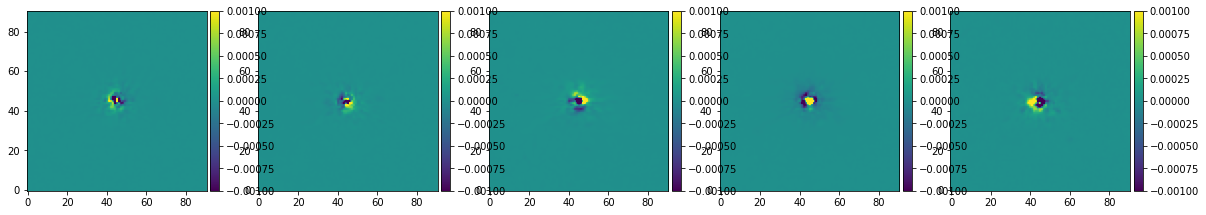

0.00014471116849986082
8.101066321603351e-05
0.0003842559722424551
0.0006110991867593576
0.00023974094315116438


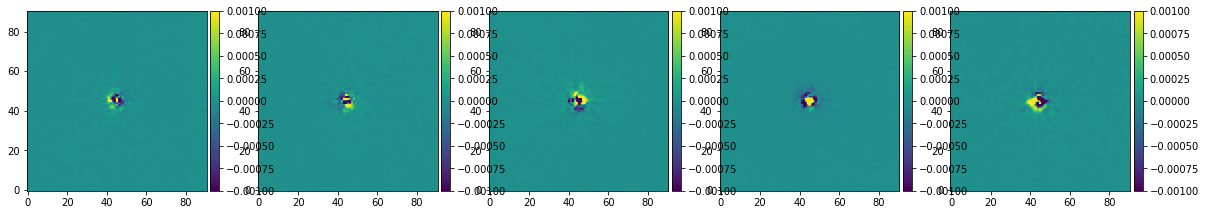

In [26]:
# fitted stars with supersampled


def plot_individual_fit_psfr(psfr, fitted_stars, center_list, oversampling):


    f, axes = plt.subplots(1, len(fitted_stars), figsize=(4*len(fitted_stars), 4), sharex=False, sharey=False)
    for i, star in enumerate(fitted_stars):
        
        center = center_list[i]
        psf_degraded = shift_psf(psfr, oversampling, center, degrade=True, n_pix_star=len(star))
        ax = axes[i]
        im = ax.imshow(psf_degraded - star/np.sum(star), origin='lower', vmin=-0.001, vmax=0.001)
        ax.autoscale(False)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)
        print(np.sum((psf_degraded - star/np.sum(star))**2))
    plt.show()


plot_individual_fit_psfr(psf_psfr_super, star_list_jwst, center_list_psfr, oversampling)

plot_individual_fit_psfr(psf_psfr, star_list_jwst, center_list_psfr, oversampling=1)



/var/folders/ff/391hnrfx0v757ybq_pmrkk_w0000gn/T/ipykernel_2688/1003116567.py:17: RuntimeWarning: invalid value encountered in log10
  im = ax.imshow(np.log10(psf_photutil), origin='lower', vmin=vmin, vmax=vmax)


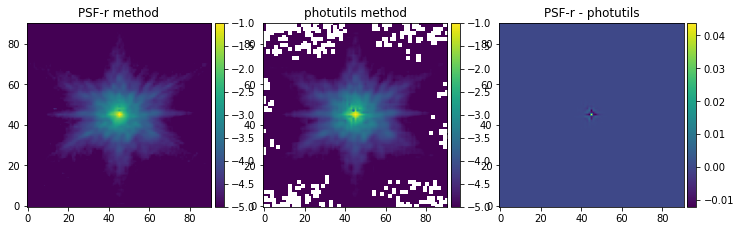

/var/folders/ff/391hnrfx0v757ybq_pmrkk_w0000gn/T/ipykernel_2688/1003116567.py:44: RuntimeWarning: invalid value encountered in log10
  im = ax.imshow(np.log10(psf_psfr_super * oversampling**2), origin='lower', vmin=vmin, vmax=vmax)
/var/folders/ff/391hnrfx0v757ybq_pmrkk_w0000gn/T/ipykernel_2688/1003116567.py:52: RuntimeWarning: invalid value encountered in log10
  im = ax.imshow(np.log10(psf_photutils_super * oversampling**2), origin='lower', vmin=vmin, vmax=vmax)


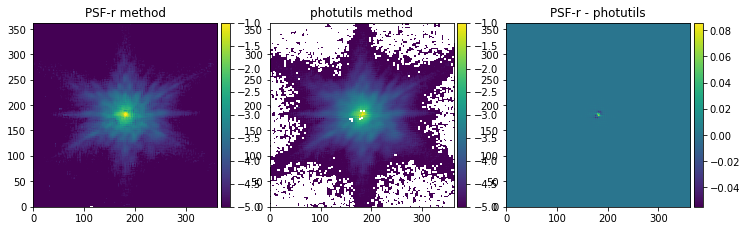

In [23]:
# regular method comparison between PSF-r and photutils

f, axes = plt.subplots(1, 3, figsize=(4*3, 4), sharex=False, sharey=False)

psf_photutil = kernel_util.cut_psf(epsf.data, psf_size=len(star_list_jwst[0]))


ax = axes[0]
im = ax.imshow(np.log10(psf_psfr), origin='lower', vmin=vmin, vmax=vmax)
ax.autoscale(False)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
ax.set_title('PSF-r method')

ax = axes[1]
im = ax.imshow(np.log10(psf_photutil), origin='lower', vmin=vmin, vmax=vmax)
ax.autoscale(False)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
ax.set_title('photutils method')

ax = axes[2]
im = ax.imshow(psf_psfr - psf_photutil, origin='lower')  # epfs_web
ax.autoscale(False)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
ax.set_title('PSF-r - photutils')

plt.show()


# supersampled comparison between PSF-r and photutils

f, axes = plt.subplots(1, 3, figsize=(4*3, 4), sharex=False, sharey=False)

psf_photutils_super = kernel_util.cut_psf(epsf_super.data, psf_size=len(psf_psfr_super))


vmin, vmax = -5, -1
ax = axes[0]
im = ax.imshow(np.log10(psf_psfr_super * oversampling**2), origin='lower', vmin=vmin, vmax=vmax)
ax.autoscale(False)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
ax.set_title('PSF-r method')

ax = axes[1]
im = ax.imshow(np.log10(psf_photutils_super * oversampling**2), origin='lower', vmin=vmin, vmax=vmax)
ax.autoscale(False)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
ax.set_title('photutils method')

ax = axes[2]
im = ax.imshow(psf_psfr_super * oversampling**2 - psf_photutils_super * oversampling**2, origin='lower')  # epfs_web
ax.autoscale(False)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
ax.set_title('PSF-r - photutils')

plt.show()
